# Covid-19 Fourth Wave by US state

In [121]:
import pandas as pd
from datetime import timedelta
from statsmodels.stats.proportion import proportions_ztest

import matplotlib
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
covid_df = pd.read_csv('../data/external/us-states.csv')
covid_df.columns = ['date', 'state', 'fips', 'cumulative_cases', 'cumulative_deaths']
covid_df.date = pd.to_datetime(covid_df.date)
covid_df = covid_df.sort_values(by=['state','date']).reset_index(drop=True)
covid_df['year'] = covid_df.date.dt.year
covid_df['month'] = covid_df.date.dt.month
covid_df['year_month'] = covid_df.date.dt.strftime('%Y-%m')

## Data cleaning

* set Florida negative date to 0

In [61]:
previous_day = covid_df[(covid_df.date == '2021-06-03') & (covid_df.state == 'Florida')].cumulative_cases.iloc[0]
next_day = covid_df[(covid_df.date == '2021-06-04') & (covid_df.state == 'Florida')].cumulative_cases.iloc[0]
print(f"Cumulative cases on 2021-06-03: {previous_day}")
print(f"Cumulative cases on 2021-06-04: {next_day}")
print(f"Diff: {next_day - previous_day}")

Cumulative cases on 2021-06-03: 2329859
Cumulative cases on 2021-06-04: 2289332
Diff: -40527


Remove small islands

In [62]:
islands = {'Guam', 'Northern Mariana Islands', 'Virgin Islands'}
covid_df = covid_df[~covid_df.state.isin(islands)].reset_index(drop=True)

In [63]:
covid_df.shape

(29598, 8)

In [64]:
covid_df.head()

,date,state,fips,cumulative_cases,cumulative_deaths,year,month,year_month
0,2020-03-13,Alabama,1,6,0,2020,3,2020-03
1,2020-03-14,Alabama,1,12,0,2020,3,2020-03
2,2020-03-15,Alabama,1,23,0,2020,3,2020-03
3,2020-03-16,Alabama,1,29,0,2020,3,2020-03
4,2020-03-17,Alabama,1,39,0,2020,3,2020-03


In [65]:
deaths = []
cases = []
for i in range(len(covid_df)):
    state = covid_df.state[i]
    previous_day = covid_df.date[i] - timedelta(days=1)
    previows_row = covid_df[(covid_df.state == state) & (covid_df.date == previous_day)]
    if len(previows_row):
        deaths.append(max(0, covid_df.cumulative_deaths[i] - previows_row.cumulative_deaths.iloc[0]))
        cases.append(max(0, covid_df.cumulative_cases[i] - previows_row.cumulative_cases.iloc[0]))
    else:
        deaths.append(covid_df.cumulative_deaths[i])
        cases.append(covid_df.cumulative_cases[i])

covid_df['deaths'] = deaths 
covid_df['cases'] = cases

In [66]:
rolling_deaths = []
rolling_cases = []

for state in sorted(covid_df.state.unique()):
    state_filtered = covid_df[covid_df.state == state].reset_index()
    state_rolling_deaths = state_filtered['deaths'].rolling(7).mean()
    state_rolling_cases = state_filtered['cases'].rolling(7).mean()
    rolling_deaths += state_rolling_deaths.to_list()
    rolling_cases += state_rolling_cases.to_list()
    
covid_df['7day_avg_deaths'] = rolling_deaths
covid_df['7day_avg_cases'] = rolling_cases

In [67]:
covid_df.tail()

,date,state,fips,cumulative_cases,cumulative_deaths,year,month,year_month,deaths,cases,7day_avg_deaths,7day_avg_cases
29593,2021-09-17,Wyoming,56,83958,918,2021,9,2021-09,0,315,5.571429,473.571429
29594,2021-09-18,Wyoming,56,83958,918,2021,9,2021-09,0,0,5.571429,473.571429
29595,2021-09-19,Wyoming,56,83958,918,2021,9,2021-09,0,0,5.571429,473.571429
29596,2021-09-20,Wyoming,56,85499,918,2021,9,2021-09,0,1541,5.571429,524.857143
29597,2021-09-21,Wyoming,56,86052,955,2021,9,2021-09,37,553,5.285714,512.714286


In [68]:
covid_df[['cases','deaths']].sum()

cases     42450775
deaths      681378
dtype: int64

In [69]:
covid_df[['cases','deaths']].describe()

,cases,deaths
count,29598.000000,29598.000000
mean,1434.244712,23.021083
std,3112.160905,60.499367
min,0.000000,0.000000
25%,108.000000,1.000000
50%,468.500000,6.000000
75%,1417.000000,22.000000
max,64986.000000,2559.000000


In [70]:
covid_df.to_csv('../data/processed/us-states.csv')

## USA metrics

In [71]:
us_covid = covid_df[['deaths','cases','date']].groupby(["date"]).sum().reset_index()
us_covid['year_month'] = us_covid.date.dt.strftime('%Y-%m')
us_covid['day_avg_deaths'] = us_covid['deaths'].rolling(7).mean()
us_covid['day_avg_cases'] = us_covid['cases'].rolling(7).mean()

In [72]:
us_covid[['cases','deaths']].describe()

,cases,deaths
count,610.000000,610.000000
mean,69591.434426,1117.013115
std,67088.313900,988.024301
min,0.000000,0.000000
25%,23732.750000,409.750000
50%,47789.000000,875.500000
75%,81768.750000,1484.500000
max,300827.000000,5463.000000


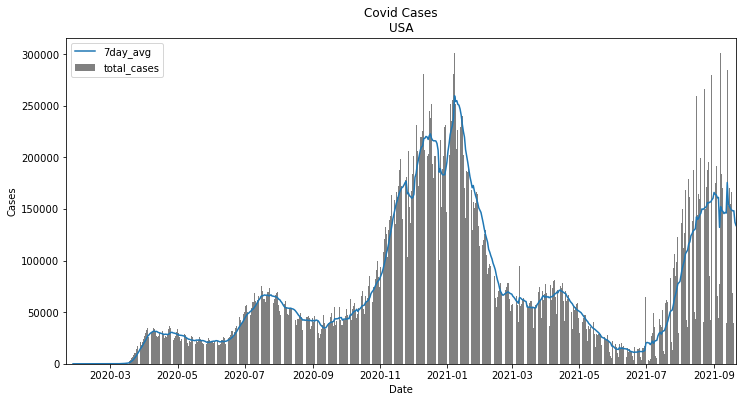

In [73]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(us_covid.date,
       us_covid.cases,
       color='gray',
      label="total_cases")
ax.plot(us_covid.date,us_covid.day_avg_cases, label='7day_avg')
ax.set(xlabel="Date",
       ylabel="Cases",
       title="Covid Cases\nUSA",
       xlim=[min(us_covid.date), max((us_covid.date))])
ax.legend(loc='best')

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
plt.show()

## US - States metrics

https://worldpopulationreview.com/cb377140-43b2-439d-96a6-1d265845acd7

In [74]:
states_population = pd.read_csv('../data/external/states_population.csv')

In [75]:
states_population.head()

,rank,State,Pop,Growth,Pop2018,Pop2010,growthSince2010,Percent,density
0,1,California,39613493,0.0038,39461588,37319502,0.0615,0.1184,254.2929
1,2,Texas,29730311,0.0385,28628666,25241971,0.1778,0.0889,113.8081
2,3,Florida,21944577,0.0330,21244317,18845537,0.1644,0.0656,409.2229
3,4,New York,19299981,-0.0118,19530351,19399878,-0.0051,0.0577,409.5400
4,5,Pennsylvania,12804123,0.0003,12800922,12711160,0.0073,0.0383,286.1704


In [89]:
total_by_state = covid_df[['state','deaths','cases']][covid_df.date > '2021-07-01'].groupby('state').sum()
total_by_state = total_by_state.join(states_population.set_index('State'))
total_by_state['relative_cases'] = total_by_state.cases / total_by_state.Pop
total_by_state['relative_deaths'] = total_by_state.deaths / total_by_state.Pop

In [90]:
total_by_state.head()

,deaths,cases,rank,Pop,Growth,Pop2018,Pop2010,growthSince2010,Percent,density,relative_cases,relative_deaths
state,,,,,,,,,,,,
Alabama,2108,224548,24,4934193,0.0095,4887681,4785437,0.0311,0.0147,97.4271,0.045509,0.000427
Alaska,103,31882,49,724357,-0.0147,735139,713910,0.0146,0.0022,1.2694,0.044014,0.000142
Arizona,1647,175410,14,7520103,0.0506,7158024,6407172,0.1737,0.0225,66.2016,0.023325,0.000219
Arkansas,1590,136768,34,3033946,0.0080,3009733,2921964,0.0383,0.0091,58.3059,0.045079,0.000524
California,4958,803289,1,39613493,0.0038,39461588,37319502,0.0615,0.1184,254.2929,0.020278,0.000125


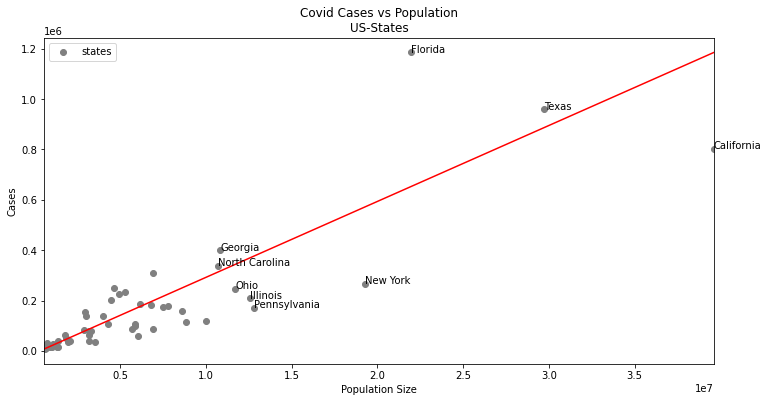

In [102]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(total_by_state.Pop,
       total_by_state.cases,
       color='gray',
      label="states")

ax.set(xlabel="Population Size",
       ylabel="Cases",
       title="Covid Cases vs Population\nUS-States",
       xlim=[min(total_by_state.Pop), max((total_by_state.Pop))])
ax.legend(loc='best')

for i, txt in enumerate(total_by_state.index):
    if total_by_state.Pop.iloc[i] > 10000000:
        ax.annotate(txt, (total_by_state.Pop.iloc[i], total_by_state.cases.iloc[i]))

line_limits_y = (total_by_state.cases.min(), total_by_state.cases.max()) 
line_limits_x = (total_by_state.Pop.min(), total_by_state.Pop.max())   
plt.plot(line_limits_x, line_limits_y, 'k-', color = 'r')

plt.show()

## Hypothesis Test

In [141]:
significance_level = 0.05 

In [139]:
print(f'US total cases: {total_by_state.cases.sum():,}')
print(f'US Estimated population: {total_by_state.Pop.sum():,}')
print(f'Cases by population: {total_by_state.cases.sum() / total_by_state.Pop.sum():.4}')
print(f'Variance: {total_by_state.relative_cases.var():.4}')
print(f'Std deviation: {total_by_state.relative_cases.std():.4}')

US total cases: 8,691,543
US Estimated population: 334,537,941
Cases by population: 0.02598
Variance: 0.0001591
Std deviation: 0.01261


In [145]:
not_reject_msg = f"The data do not provide enough statistical evidence to say that, the proportion of covid-19 cases are different, with significance level of {significance_level:%}."
reject_msg = f"The data provide enough statistical evidence to say that, the proportion of covid-19 cases are different, with significance level of {significance_level:.0%}."

### Florida

In [146]:
print(f'Florida total cases: {total_by_state.cases["Florida"]:,}')
print(f'Florida cases from US total: {total_by_state.cases["Florida"] / total_by_state.cases.sum():.4}')
print(f'Florida estimated population: {total_by_state.Pop["Florida"]:,}')
print(f'Florida cases by population: {total_by_state.cases["Florida"] / total_by_state.Pop["Florida"]:.4}')

Florida total cases: 1,185,261
Florida cases from US total: 0.1364
Florida estimated population: 21,944,577
Florida cases by population: 0.05401


In [147]:
stat, pval = proportions_ztest(count=total_by_state.cases["Florida"],
                  nobs=total_by_state.Pop["Florida"],
                  value=total_by_state.cases.sum() / total_by_state.Pop.sum(),
                 alternative='larger',
                 prop_var=total_by_state.relative_cases.var())
print(f'Z-stat: {stat}')
print(f'P-value: {pval}')
if pval < significance_level:
    print(reject_msg)
else:
    print(not_reject_msg)

Z-stat: 10411.952175460827
P-value: 0.0
The data provide enough statistical evidence to say that, the proportion of covid-19 cases are different, with significance level of 5%.


### New York

In [133]:
print(f'New York total cases: {total_by_state.cases["New York"]:,}')
print(f'New York cases from US total: {total_by_state.cases["New York"] / total_by_state.cases.sum():.4}')
print(f'New York estimated population: {total_by_state.Pop["New York"]:,}')
print(f'New York cases by population: {total_by_state.cases["New York"] / total_by_state.Pop["New York"]:.4}')

New York total cases: 266,620
New York cases from US total: 0.03068
New York estimated population: 19,299,981
New York cases by population: 0.01381


In [149]:
stat, pval = proportions_ztest(count=total_by_state.cases["New York"],
                  nobs=total_by_state.Pop["New York"],
                  value=total_by_state.cases.sum() / total_by_state.Pop.sum(),
                 alternative='smaller',
                 prop_var=total_by_state.relative_cases.var())
print(f'Z-stat: {stat}')
print(f'P-value: {pval}')
if pval < significance_level:
    print(reject_msg)
else:
    print(not_reject_msg)

Z-stat: -4238.055667104175
P-value: 0.0
The data provide enough statistical evidence to say that, the proportion of covid-19 cases are different, with significance level of 5%.


## TODO
* Check Z-test values (too high)
* Show cases vs density of the city
* Test correlation with mask usage